# **GNN_Energy.ipynb: Energy prediction for EIC Det2 KLM**
This notebook walks through the steps of loading data, training and testing a GNN for energy prediction tasks

In [1]:
# import matplotlib.pyplot as plot
import pandas as pd
import os
os.environ["DGLBACKEND"] = "pytorch"
import dgl
import torch
from dgl.data import DGLDataset
import matplotlib.pyplot as plot
import numpy as np
import torch.nn as nn
import torch
import itertools
import dgl.data
import torch.nn.functional as F
from dgl.nn import GraphConv,SumPooling,GINConv,AvgPooling,MaxPooling
from dgl.dataloading import GraphDataLoader
from tqdm import tqdm
import matplotlib.pyplot as plot
from datetime import datetime as datetime
current_date = datetime.now().strftime("%B_%d")
from torch.utils.data.sampler import SubsetRandomSampler
from scipy.spatial import ConvexHull
from GNN_util import process_df_vectorized,create_directory,HitDataset,create_fast_edge_lists,visualize_detector_graph,GIN,train_GNN,test_GNN_binned,calculate_bin_rmse
from torchviz import make_dot

/hpc/group/vossenlab/rck32/ML_venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


## **Load in Data**
The data is stored as pandas dataframes where each row is a hit in the detector

In [2]:
num_dfs = 20
dfs = []
for i in range(0,0 + num_dfs):
    try: 
#         new_df = pd.read_csv(f"/hpc/group/vossenlab/rck32/eic/work_eic/macros/Timing_estimation/data/df/Consistency_test_thick_steel_geometry_1kevents_March_26_neutron_0_5GeV_to_5GeV1000events_run_4_{i}.csv") #thick steel
        new_df = pd.read_csv(f"/hpc/group/vossenlab/rck32/eic/work_eic/macros/Timing_estimation/data/df/Consistency_test_status_quo_geometry_1kevents_March_25_neutron_0_5GeV_to_5GeV1000events_run_2_{i}.csv") 
#         new_df = pd.read_csv(f"/hpc/group/vossenlab/rck32/eic/work_eic/macros/Timing_estimation/data/df/Consistency_test_status_quo_geometry_5kevents_March_25_neutron_0_5GeV_to_5GeV1000events_run_1_{i}.csv") 
    except FileNotFoundError as e:
        # Skip files that failed for some reason...
        # I think these files fail due to DCC issues?
        print(f"skipping file #{i}...")
        continue
    new_df["file_idx"] = i
    dfs.append(new_df)
if(len(dfs) > 1):
    data = pd.concat(dfs)
else:
    data = dfs[0]

## **Isolate hits in one section of detector**

Because we sometimes get backscattering and other weird detector effects, we want to train the GNN on a cluster of events that are all together, and treat hits that are far away as noise. This implementation allows the user to set how far away the hits can be and still be clustered together

In [3]:
# Plot the data
modified_df = process_df_vectorized(data, cone_angle_deg = 40)

## **Define the dataset class for easy management**

The HitDataset class inherits from the DGLDataset. The required member functions are the init method, process, getitem, and len.

In [4]:
dataset = HitDataset(modified_df,True,connection_mode = "kNN",k = 6)
print("done")

done


In [5]:
print(len(dataset))

19314


## **Optionally, we can visualize any of the input graphs below**

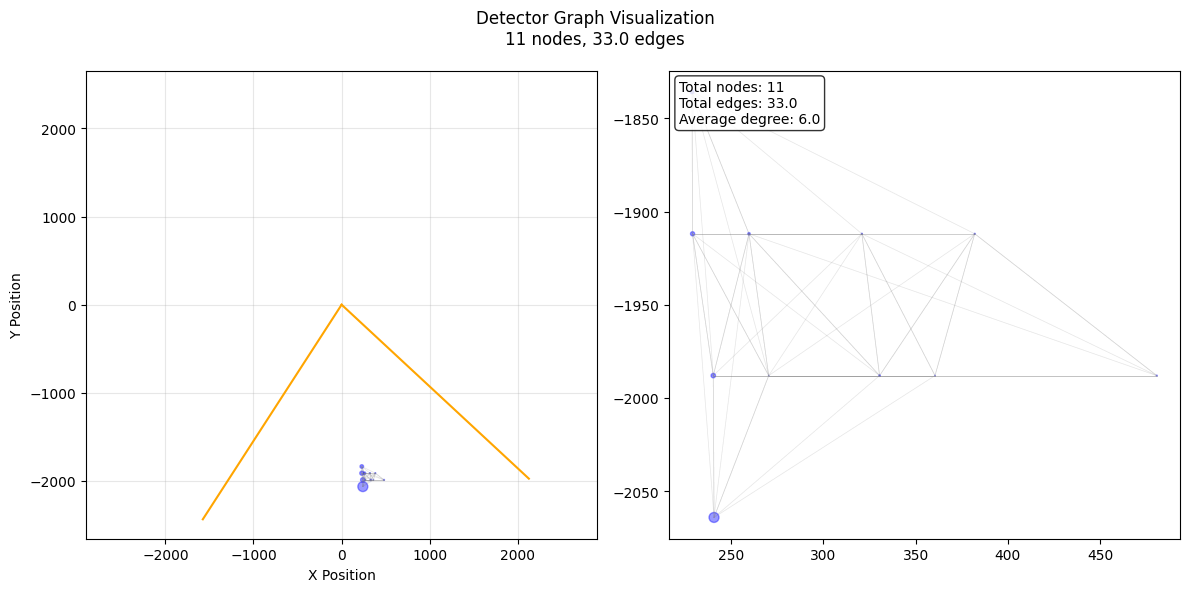

In [6]:
visualize_detector_graph(dataset,graph_idx = 1)

## **Define dataloader**

We use a dataloader to make batching easier, and to randomly split test and train

In [7]:
train_frac = 0.7
val_frac = 0.15
num_train = int(np.floor(len(dataset) * train_frac))
# num_train = 5
num_val = int(np.floor(len(dataset) * val_frac))
num_examples = len(dataset)

train_sampler = SubsetRandomSampler(torch.arange(num_train))
val_sampler = SubsetRandomSampler(torch.arange(num_train, num_val + num_train))
test_sampler = SubsetRandomSampler(torch.arange(num_val + num_train, num_examples))

train_dataloader = GraphDataLoader(
    dataset, sampler=train_sampler, batch_size=20, drop_last=False
)

val_dataloader = GraphDataLoader(
    dataset, sampler=val_sampler, batch_size=20, drop_last=False
)

test_dataloader = GraphDataLoader(
    dataset, sampler=test_sampler, batch_size=20, drop_last=False
)

## **Initialize the model and define the optimizer/criterion**

In [8]:
run_num = 1
geometry_type = 2

1. MLP hidden dim = 43
1. linear capacity = 3
1. linear layers = 7
1. conv layers = 1
1. lr = 4e-4

In [9]:

# Test:
hidden_dim = 32
linear_capacity = 5
early_stopping_limit = 8
n_conv_layers = 2
n_linear_layers = 7
lr = 5e-5

In [10]:

class GIN(nn.Module):
    def __init__(self, in_feats, h_feats,num_event_feats,n_conv_layers = 2, n_linear_layers = 7,linear_capacity = 5, num_classes=1,pooling_type = "avg"):
        super(GIN, self).__init__()
        # Define the MLP for the GINConv layers
        conv_list = []
        for i in range(n_conv_layers):
            first_in = (in_feats if i == 0 else h_feats)
            mlp = nn.Sequential(
                nn.Linear(first_in, h_feats),
                nn.ReLU(),
                nn.Linear(h_feats, h_feats)
            )
            conv_list.append(GINConv(mlp))
        self.conv_list = nn.ModuleList(conv_list)
        
        # Define the GINConv layers
        
        linear_list = []
        for i in range(n_linear_layers):
            if(i == 0):
                in_feats = h_feats + num_event_feats
#                 in_feats = h_feats
#                 in_feats = num_event_feats
                out_feats = pow(2,linear_capacity + (n_linear_layers // 2))
            elif(i == n_linear_layers - 1):
                in_feats = out_feats
                out_feats = num_classes
            else:
                in_feats = out_feats
                out_feats = out_feats // (2 if (i %2) else 1)
            linear_list.append(nn.Linear(in_feats,out_feats))
        self.linear_list = nn.ModuleList(linear_list)
        
        # Graph pooling layer
        if(pooling_type == "avg"):
            self.pool = AvgPooling()
        elif(pooling_type == "sum"):
            self.pool = SumPooling()
        elif(pooling_type == "max"):
            self.pool = MaxPooling()
        else:
            print(f"Selected pooling type \"{pooling_type}\" not found. Resorting to default: AvgPooling")
            self.pool = AvgPooling()

    def forward(self, g, in_feat,event_feats):
        # Apply the first GINConv layer
        
        h = in_feat
        hidden_reps = []
        for i in range(len(self.conv_list)):
            h = self.conv_list[i](g,h)
            h = F.relu(h)
            hidden_reps.append(self.pool(g,h))
        
        # Pool the graph-level representation - gives one array of length n_feats
        hg = self.pool(g, h)
        for i in range(len(hidden_reps)):
            hg += hidden_reps[i]
#         print(f"event feats 0: {event_feats[:,0]}")
#         total_feats = event_feats.float()#.unsqueeze(-1)
        total_feats = torch.cat((hg,event_feats),axis = 1).float()
#         total_feats = hg
        for i in range(len(self.linear_list) - 1):
            total_feats = self.linear_list[i](total_feats)
            total_feats = F.relu(total_feats)
            
        #No activation on last linear layer:
        total_feats = self.linear_list[-1](total_feats)
        return total_feats

In [47]:
def train_GNN(model,optimizer,criterion, train_dataloader, val_dataloader, n_epochs,early_stopping_limit,frame_plot_path = "",model_path = "",log_status = True):
    create_directory(model_path)
    val_mse = []
    val_mse_all = []
    val_mse_binned = []
    train_losses = []
    train_losses_all = []
    early_stopping_dict = {
            "lowest_loss" : -1,
            "best_model_path" : "",
            "num_upticks" : 0,
            "best_epoch": 0
    }
    # 0: loss; 1: path; 2: # hits

    for epoch in range(n_epochs):
        model.train()
        num_train_batches = 0
        epoch_train_losses = 0.0
        train_preds = torch.tensor([])
        train_truths = torch.tensor([])
        
        
        for batched_graph, labels_w_event_feats in train_dataloader:
            labels = labels_w_event_feats[:,0]
            event_feats = labels_w_event_feats[:,1:]
#             print(f"labels: {labels}")
#             print(f"labels: {labels}\n event_feat: {event_feats}")
            pred = model(batched_graph, batched_graph.ndata["feat"].float(),event_feats)
            loss = criterion(pred, labels.unsqueeze(-1))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            epoch_train_losses+=loss.detach()
            train_losses_all.append(loss.detach())
            num_train_batches += 1
            train_preds = torch.cat([train_preds,pred.detach()])
            train_truths = torch.cat([train_truths,labels])
        # Average RMSE for the epoch
        this_epoch_loss = epoch_train_losses / num_train_batches
        train_losses.append(this_epoch_loss)
        # Testing phase
        model.eval()
        epoch_val_mse = 0.0
        num_val_batches = 0
        val_preds = torch.tensor([])
        val_truths = torch.tensor([])
        with torch.no_grad():  # Disable gradients for evaluation
            for batched_graph, labels_w_event_feats in val_dataloader:
                labels = labels_w_event_feats[:,0]
                event_feats = labels_w_event_feats[:,1:]
                pred = model(batched_graph, batched_graph.ndata["feat"].float(),event_feats)
                # Calculate RMSE for this batch
                batch_mse = criterion(pred, labels.unsqueeze(-1))
                epoch_val_mse += batch_mse
                num_val_batches += 1
                val_mse_all.append(batch_mse)
                val_preds = torch.cat([val_preds,pred])
                val_truths = torch.cat([val_truths,labels])

        # Average RMSE for the test set
        epoch_val_mse /= num_val_batches
        val_mse.append(epoch_val_mse)
        
        test_truths, test_preds, test_rmse,binned_rmse = test_GNN_binned(model, val_dataloader)
        val_mse_binned.append(binned_rmse)
        
        if(epoch %1 == 0):
            if(log_status):
                print(f"Epoch {epoch + 1}/{n_epochs} - Train loss:\t {this_epoch_loss:.4f}")
                print(f"Epoch {epoch + 1}/{n_epochs} - Validation Criterion:\t {epoch_val_mse:.4f}\n")
            if(frame_plot_path != ""):
                frame_fig, frame_axs = plot.subplots(1,1)
                frame_axs.plot([0,5],[0,5])
                frame_fig.suptitle("Test dataset results")
                frame_axs.scatter(val_truths,val_preds,alpha = 0.05,color = "red",label = "val")
    #             plot.scatter(train_truths,train_preds,alpha = 0.01,color = "blue",label = "train")
                frame_axs.set_xlabel("truths")
                frame_axs.set_ylabel("preds")
                frame_axs.text(3.1,1.3, f"Epoch #{epoch + 1}\nTrain, val loss: ({this_epoch_loss:.4f},{epoch_val_mse:.4f})")
                frame_fig.tight_layout()
                frame_fig.savefig(f"{frame_plot_path}epoch{epoch}.jpeg")
        
        if(epoch_val_mse.item() < early_stopping_dict["lowest_loss"] or early_stopping_dict["lowest_loss"] == -1):
            early_stopping_dict["lowest_loss"] = epoch_val_mse
            early_stopping_dict["best_model_path"] = f"{model_path}epoch_{epoch}.pth"
            early_stopping_dict["num_upticks"] = 0
            early_stopping_dict["best_epoch"] = epoch
            
            torch.save(model.state_dict(),early_stopping_dict["best_model_path"])
        elif(epoch_val_mse.item() > early_stopping_dict["lowest_loss"]):
            early_stopping_dict["num_upticks"] += 1
            if(log_status):
                print("Test loss increased, adding uptick")
        if(early_stopping_dict["num_upticks"] >= early_stopping_limit):
            # Stop training, load best model
            model.load_state_dict(torch.load(early_stopping_dict["best_model_path"]))
            torch.save(model.state_dict(),f"{model_path}best_model.pth")
            if(log_status):
                print("Stopping early, loading current model...")
            break
    return model, train_losses, val_mse, optimizer,early_stopping_dict["best_epoch"],val_mse_binned

In [ ]:
model = GIN(dataset.dim_nfeats,hidden_dim,dataset.dim_event_feats,n_conv_layers = n_conv_layers, n_linear_layers = n_linear_layers,linear_capacity = linear_capacity)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()
# criterion = weighted_mse_loss

*Now we can actually train the model*

In [13]:
model_path = f"/hpc/group/vossenlab/rck32/eic/work_eic/macros/Timing_estimation/models/{current_date}/energy_only/"

In [40]:
n_epochs = 300
trained_model, train_losses, val_losses, optimizer,best_epoch,val_mse_binned = train_GNN(model,optimizer,criterion, train_dataloader, val_dataloader, n_epochs, early_stopping_limit, model_path = model_path)

Epoch 1/300 - Train loss:	 2.1698
Epoch 1/300 - Validation Criterion:	 0.7531

Epoch 2/300 - Train loss:	 0.6544
Epoch 2/300 - Validation Criterion:	 0.5920

Epoch 3/300 - Train loss:	 0.5509
Epoch 3/300 - Validation Criterion:	 0.5243

Epoch 4/300 - Train loss:	 0.4918
Epoch 4/300 - Validation Criterion:	 0.5181

Epoch 5/300 - Train loss:	 0.4714
Epoch 5/300 - Validation Criterion:	 0.4711

Epoch 6/300 - Train loss:	 0.4442
Epoch 6/300 - Validation Criterion:	 0.4505

Epoch 7/300 - Train loss:	 0.4409
Epoch 7/300 - Validation Criterion:	 0.4425

Epoch 8/300 - Train loss:	 0.4319
Epoch 8/300 - Validation Criterion:	 0.4394

Epoch 9/300 - Train loss:	 0.4199
Epoch 9/300 - Validation Criterion:	 0.4323

Epoch 10/300 - Train loss:	 0.4131
Epoch 10/300 - Validation Criterion:	 0.4699

Test loss increased, adding uptick
Epoch 11/300 - Train loss:	 0.4126
Epoch 11/300 - Validation Criterion:	 0.4317

Epoch 12/300 - Train loss:	 0.4049
Epoch 12/300 - Validation Criterion:	 0.4653

Test loss i

## **Plot training and val loss on log scale**

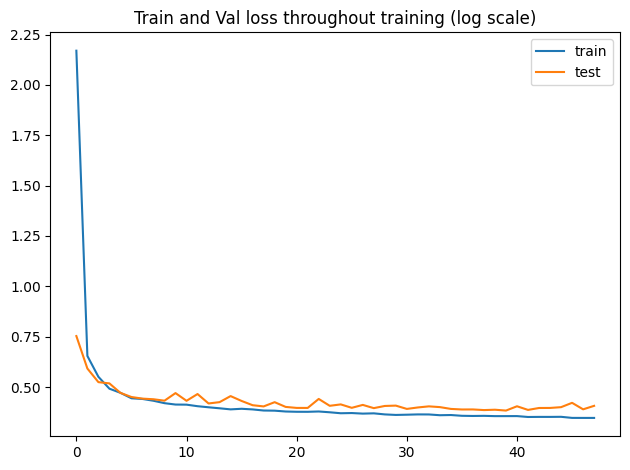

In [41]:
plot.plot(train_losses,label = "train")
plot.title("Train and Val loss throughout training (log scale)")
plot.plot(val_losses, label = "test")
plot.legend()
plot.tight_layout()

## **Evaluate model on test dataset**

Now we can check the RMSE and across the whole test dataset and visualize the result

RMSE: 0.6073653697967529
RMSE for E < 2.75GeV: 0.47120689263588994; E > 2.75GeV: 0.7070279164740975


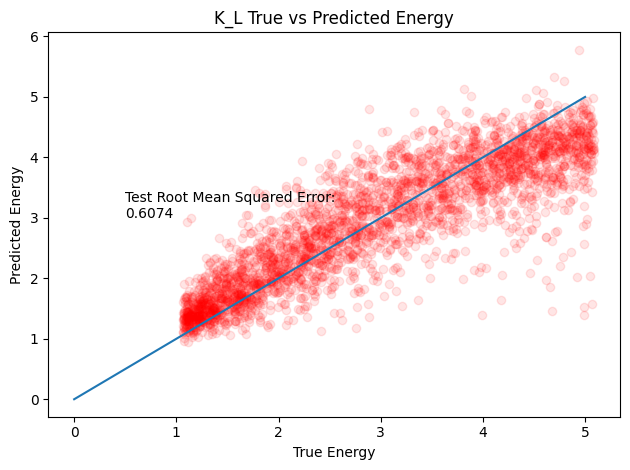

In [43]:
test_truths, test_preds, test_rmse,binned_rmse = test_GNN_binned(trained_model, test_dataloader)
# print(f"binned_rmse: {binned_rmse}")
plot.plot([0,5],[0,5])
plot.title("K_L True vs Predicted Energy")
plot.scatter(test_truths,test_preds,alpha = 0.1,color = "r")
plot.xlabel("True Energy")
plot.ylabel("Predicted Energy")
plot.text(0.5,3,f"Test Root Mean Squared Error:\n{test_rmse:0.4f}")
plot.tight_layout()
# plot.ylim(1,2)
# plot.xlim(1,2)
# plot.savefig("plots/GNN/March_17_predsvtruth.jpeg")

In [45]:
# binned_rmses = []
# model_val_losses = []
val_binned_rmses_epochs = []

In [48]:

model_path = f"/hpc/group/vossenlab/rck32/eic/work_eic/macros/Timing_estimation/models/{current_date}/energy_only/"
for i in range(20):
    model = GIN(dataset.dim_nfeats,hidden_dim,dataset.dim_event_feats,n_conv_layers = n_conv_layers, n_linear_layers = n_linear_layers,linear_capacity = linear_capacity)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    n_epochs = 300
    trained_model, train_losses, val_losses, optimizer,best_epoch,val_mse_binned = train_GNN(model,optimizer,criterion, train_dataloader, val_dataloader, n_epochs, early_stopping_limit, model_path = model_path)
    test_truths, test_preds, test_rmse,binned_rmse = test_GNN_binned(trained_model, test_dataloader)
    binned_rmses.append(binned_rmse)
    model_val_losses.append(val_losses)
    val_binned_rmses_epochs.append(val_mse_binned)
    


RMSE: 0.8534161448478699
RMSE for E < 2.75GeV: 0.6507606546785115; E > 2.75GeV: 0.9899213136036782
Epoch 1/300 - Train loss:	 1.6360
Epoch 1/300 - Validation Criterion:	 0.7283

RMSE: 0.7860996127128601
RMSE for E < 2.75GeV: 0.6042726675884023; E > 2.75GeV: 0.9091936025086355
Epoch 2/300 - Train loss:	 0.6275
Epoch 2/300 - Validation Criterion:	 0.6179

RMSE: 0.7401561141014099
RMSE for E < 2.75GeV: 0.5614438896177478; E > 2.75GeV: 0.8601407295787199
Epoch 3/300 - Train loss:	 0.5415
Epoch 3/300 - Validation Criterion:	 0.5476

RMSE: 0.7121420502662659
RMSE for E < 2.75GeV: 0.539189785245674; E > 2.75GeV: 0.8281252386959322
Epoch 4/300 - Train loss:	 0.4924
Epoch 4/300 - Validation Criterion:	 0.5070

RMSE: 0.698624849319458
RMSE for E < 2.75GeV: 0.48598524422948536; E > 2.75GeV: 0.8342690071374254
Epoch 5/300 - Train loss:	 0.4603
Epoch 5/300 - Validation Criterion:	 0.4879

RMSE: 0.6879487037658691
RMSE for E < 2.75GeV: 0.5825933817916059; E > 2.75GeV: 0.76404748397088
Epoch 6/300 - 

In [50]:
np.array(binned_rmses)

array([[0.47418482, 0.70235904],
       [0.47578152, 0.71793617],
       [0.50163552, 0.69430834],
       [0.49998098, 0.70125567],
       [0.47889369, 0.71004473],
       [0.50338991, 0.71412654],
       [0.50647768, 0.70337798],
       [0.49634454, 0.70143317],
       [0.48677855, 0.68931638],
       [0.49357663, 0.68882538],
       [0.48065522, 0.70920395],
       [0.50978023, 0.6887823 ],
       [0.51702292, 0.68412649],
       [0.49716578, 0.69368952],
       [0.48174223, 0.69895824],
       [0.48090013, 0.70039129],
       [0.48750497, 0.7089387 ],
       [0.50062107, 0.68844014],
       [0.49530892, 0.69271321],
       [0.49102097, 0.70028911],
       [0.48581742, 0.69411414],
       [0.48104962, 0.69782669],
       [0.49679598, 0.69131035],
       [0.47369103, 0.70834939],
       [0.47579754, 0.70729752],
       [0.49226727, 0.7077156 ],
       [0.48883536, 0.68845038],
       [0.48972004, 0.69719531],
       [0.47884211, 0.70931386],
       [0.46616287, 0.71333792],
       [0.

In [51]:
model_val_losses_list = []
for ml in model_val_losses:
    new_list = [x.item() for x in ml]
    model_val_losses_list.append(new_list)
model_val_losses_list

[[0.84046870470047,
  0.6048131585121155,
  0.5287848114967346,
  0.5028037428855896,
  0.5171841979026794,
  0.48172682523727417,
  0.4859100878238678,
  0.46071672439575195,
  0.472040593624115,
  0.45910897850990295,
  0.4522053301334381,
  0.4511794447898865,
  0.4516535699367523,
  0.4558492600917816,
  0.4357830584049225,
  0.44166576862335205,
  0.42975980043411255,
  0.4416090250015259,
  0.4294404983520508,
  0.4302977919578552,
  0.42005541920661926,
  0.41866403818130493,
  0.41511836647987366,
  0.44699516892433167,
  0.40989866852760315,
  0.4709186851978302,
  0.42469874024391174,
  0.41019901633262634,
  0.40664035081863403,
  0.40996721386909485,
  0.41234052181243896,
  0.4394373893737793,
  0.4129870533943176,
  0.4130994975566864,
  0.40544912219047546,
  0.39440298080444336,
  0.40520191192626953,
  0.39942336082458496,
  0.40119585394859314,
  0.4028873145580292,
  0.4193320870399475,
  0.40726563334465027,
  0.40023159980773926,
  0.3959963023662567],
 [0.79662150

In [58]:
val_binned_rmses_epochs_list = []
for l in val_binned_rmses_epochs:
    new_list = [list(x) for x in l]
    val_binned_rmses_epochs_list.append(new_list)
val_binned_rmses_epochs_list

[[[np.float64(0.6507606546785115), np.float64(0.9899213136036782)],
  [np.float64(0.6042726675884023), np.float64(0.9091936025086355)],
  [np.float64(0.5614438896177478), np.float64(0.8601407295787199)],
  [np.float64(0.539189785245674), np.float64(0.8281252386959322)],
  [np.float64(0.48598524422948536), np.float64(0.8342690071374254)],
  [np.float64(0.5825933817916059), np.float64(0.76404748397088)],
  [np.float64(0.5088852691025382), np.float64(0.7842623650865678)],
  [np.float64(0.6140952415389922), np.float64(0.7404596263146663)],
  [np.float64(0.49080550136482104), np.float64(0.7829720688147238)],
  [np.float64(0.47134912940679086), np.float64(0.7974769501371344)],
  [np.float64(0.5286951159983055), np.float64(0.7563128465924525)],
  [np.float64(0.5281879141390105), np.float64(0.7369646833760313)],
  [np.float64(0.47324500575450845), np.float64(0.7960302142791567)],
  [np.float64(0.4717571183749923), np.float64(0.7684608503171714)],
  [np.float64(0.5336466176144427), np.float64(0

mean, std: 0.40324825048446655, 0.004737137816846371
% error: 1.1747448444366455%


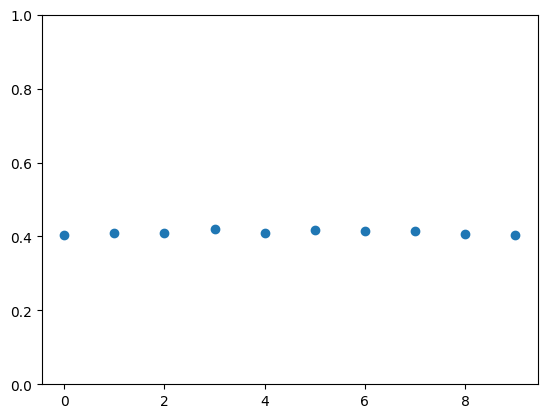

In [30]:
avgs = []
for i in range(len(model_val_losses)):
    avgs.append(np.mean(np.array(model_val_losses[i])[-5:]))
plot.scatter(range(len(avgs)),avgs)
plot.ylim(0,1)
std = np.std(np.array(model_val_losses[i])[-5:])
mean = np.mean(np.array(model_val_losses[i])[-5:])
print(f"mean, std: {mean}, {std}")
print(f"% error: {100 * std / mean}%")

mean, std: 0.40015944838523865, 0.005362518597394228
% error: 1.3400954008102417%


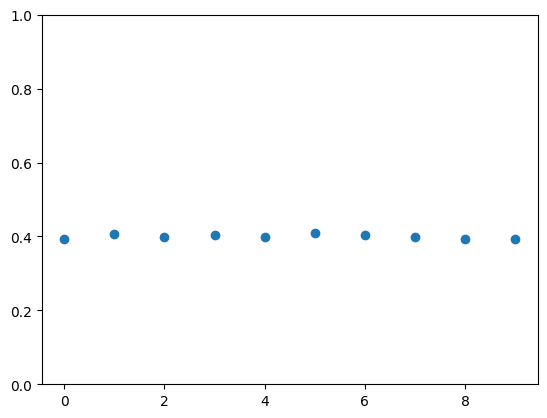

In [29]:
mins = [min(x) for x in model_val_losses]
plot.scatter(range(len(mins)),mins)
plot.ylim(0,1)
std = np.std(np.array(mins))
mean = np.mean(np.array(mins))
print(f"mean, std: {mean}, {std}")
print(f"% error: {100 * std / mean}%")

In [ ]:
avg_across_models = []
for i in range(10):
plot.scatter(range(len(mins)),mins)
plot.ylim(0,1)
std = np.std(np.array(mins))
mean = np.mean(np.array(mins))
print(f"mean, std: {mean}, {std}")
print(f"% error: {100 * std / mean}%")

In [21]:
# Run 3:
# Thick steel geometry (0.95 ratio)
# hidden_dim = 32
# linear_capacity = 5
# early_stopping_limit = 8
# n_conv_layers = 2
# n_linear_layers = 7
# lr = 5e-5

# Run 2:
# status quo geometry
# hidden_dim = 32
# linear_capacity = 5
# early_stopping_limit = 8
# n_conv_layers = 2
# n_linear_layers = 7
# lr = 5e-5
results_run_2 = [np.array([0.47680754, 0.69616156]),
 np.array([0.48205331, 0.69371943]),
 np.array([0.50743399, 0.7062432 ]),
 np.array([0.49544301, 0.71127527]),
 np.array([0.46124511, 0.70066392]),
 np.array([0.48409839, 0.70619878]),
 np.array([0.50697619, 0.69471931]),
 np.array([0.47609963, 0.71617119]),
 np.array([0.46109237, 0.71169262]),
 np.array([0.49443444, 0.6956393 ]),
 np.array([0.48546574, 0.69725427]),
 np.array([0.45948978, 0.70829879]),
 np.array([0.49310169, 0.70939995]),
 np.array([0.49592359, 0.71474688]),
 np.array([0.47332838, 0.71555422]),
 np.array([0.48651898, 0.68774432]),
 np.array([0.48036963, 0.70490429]),
 np.array([0.51531678, 0.69467133]),
 np.array([0.47619209, 0.69832334]),
 np.array([0.49022622, 0.70580539])]



# Run 1:
# hidden_dim = 32
# linear_capacity = 5
# early_stopping_limit = 4
# n_conv_layers = 2
# n_linear_layers = 7
# lr = 1e-4
results = [(0.5003006865104995,0.7193403191010951),
           (0.5340366845553881,0.6887496532270431),
           (0.47504288505886544,0.6974863532665064),
           (0.49794502741595265,0.6968041190834479),
           (0.47955089673633,0.7276237110022417),
           (0.4807943453914322,0.7278984079224163),
           (0.5113443308913256,0.7150284894793445),
           (0.49866238255396345,0.6952833811170718),
           (0.4751141514232743,0.7195951265105225),
           (0.5003700693995976,0.6897119502937938)]

Low E RMSE (mean,sigma): (0.4851,0.014992988312559807)
High E RMSE (mean,sigma): (0.7034593671942437,0.00814944818160198)


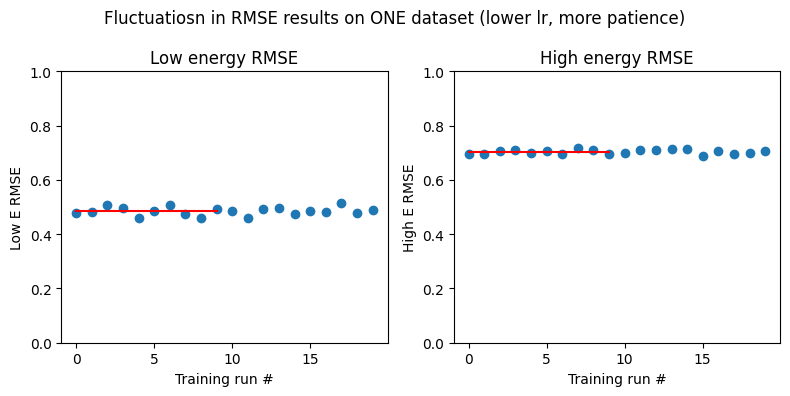

In [27]:
fig, axs = plot.subplots(1,2,figsize = (8,4))
fig.suptitle("Fluctuatiosn in RMSE results on ONE dataset (lower lr, more patience)")
axs[0].set_title("Low energy RMSE")
axs[0].scatter(range(len(results_run_2)),[result[0] for result in results_run_2])
axs[0].set_ylim(0,1)
axs[0].set_ylabel("Low E RMSE")
axs[0].set_xlabel("Training run #")
axs[0].plot([0,9],[np.mean([result[0] for result in results_run_2]),np.mean([result[0] for result in results_run_2])],color = 'r')
axs[1].set_title("High energy RMSE")
axs[1].scatter(range(len(results_run_2)),[result[1] for result in results_run_2])
axs[1].set_ylim(0,1)
axs[1].set_ylabel("High E RMSE")
axs[1].set_xlabel("Training run #")
axs[1].plot([0,9],[np.mean([result[1] for result in results_run_2]),np.mean([result[1] for result in results_run_2])],color = 'r')
fig.tight_layout()

low_RMSEs_2 = np.array([result[0] for result in results_run_2])
high_RMSEs_2 = np.array([result[1] for result in results_run_2])

low_sigma_2 = np.std(low_RMSEs_2)
low_mean_2 = np.mean(low_RMSEs_2)
high_sigma_2 = np.std(high_RMSEs_2)
high_mean_2 = np.mean(high_RMSEs_2)
print(f"Low E RMSE (mean,sigma): ({low_mean_2.item():0.4f},{low_sigma_2.item():0.4f})")
print(f"High E RMSE (mean,sigma): ({high_mean_2.item():0.4f},{high_sigma_2.item():0.4f})")

Low E RMSE (mean,sigma): (np.float64(0.4953161459936629), np.float64(0.01761598816603793))
High E RMSE (mean,sigma): (np.float64(0.7077521511003483), np.float64(0.01481721082704319))


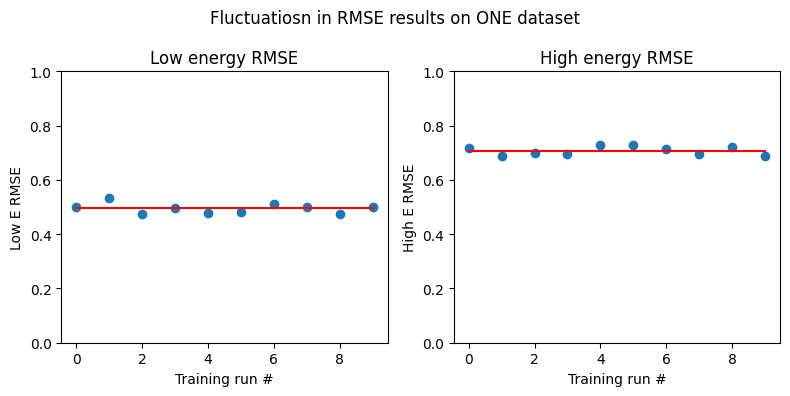

In [25]:
fig, axs = plot.subplots(1,2,figsize = (8,4))
fig.suptitle("Fluctuatiosn in RMSE results on ONE dataset")
axs[0].set_title("Low energy RMSE")
axs[0].scatter(range(len(results)),[result[0] for result in results])
axs[0].set_ylim(0,1)
axs[0].set_ylabel("Low E RMSE")
axs[0].set_xlabel("Training run #")
axs[0].plot([0,9],[np.mean([result[0] for result in results]),np.mean([result[0] for result in results])],color = 'r')
axs[1].set_title("High energy RMSE")
axs[1].scatter(range(len(results)),[result[1] for result in results])
axs[1].set_ylim(0,1)
axs[1].set_ylabel("High E RMSE")
axs[1].set_xlabel("Training run #")
axs[1].plot([0,9],[np.mean([result[1] for result in results]),np.mean([result[1] for result in results])],color = 'r')
fig.tight_layout()
# fig.savefig("fluctuations_same_dataset.pdf")

low_RMSEs_1 = np.array([result[0] for result in results])
high_RMSEs_1 = np.array([result[1] for result in results])

low_sigma_1 = np.std(low_RMSEs_1)
low_mean_1 = np.mean(low_RMSEs_1)
high_sigma_1 = np.std(high_RMSEs_1)
high_mean_1 = np.mean(high_RMSEs_1)
print(f"Low E RMSE (mean,sigma): {low_mean_1,low_sigma_1}")
print(f"High E RMSE (mean,sigma): {high_mean_1,high_sigma_1}")

In [278]:
test_truths_arr = np.array(test_truths)
test_preds_arr = np.array(test_preds)

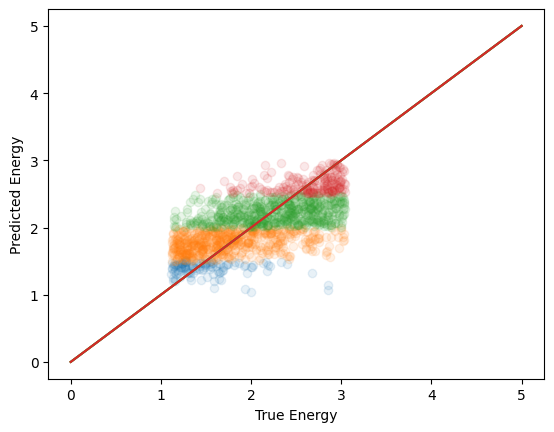

In [288]:

cut_vals = [(1,1.5),(1.5,2),(2,2.5),(2.5,3)]
pred_means = []
true_means = []
for i in range(4):
    mask_low = np.logical_and((test_preds_arr > cut_vals[i][0]),(test_preds_arr < cut_vals[i][1]))
    test_truths_cut = test_truths_arr[mask_low]
    test_preds_cut = test_preds_arr[mask_low]
    plot.scatter(test_truths_cut,test_preds_cut,alpha = 0.1)
    plot.plot([0,5],[0,5])
    plot.ylabel("Predicted Energy")
    plot.xlabel("True Energy")
    

    pred_mean = np.mean(test_preds_cut)
    true_mean = np.mean(test_truths_cut)
    
    pred_means.append(pred_mean)
    true_means.append(true_mean)

Text(0.5, 0, 'true means')

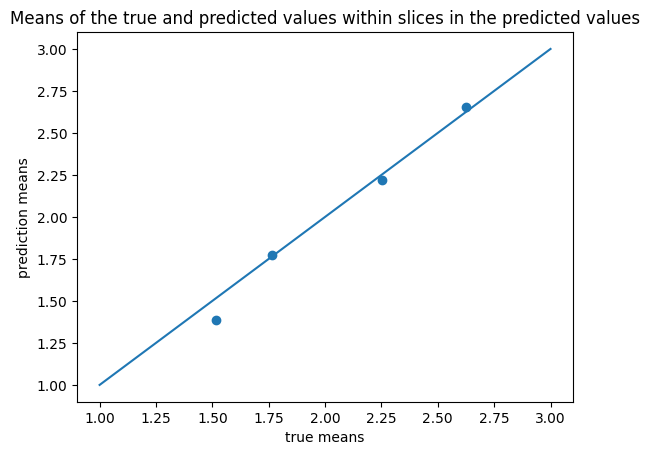

In [289]:
plot.title("Means of the true and predicted values within slices in the predicted values")
plot.scatter(true_means,pred_means)
plot.plot([1,3],[1,3])
plot.ylabel("prediction means")
plot.xlabel("true means")

# Binned RMSE

In [32]:
def calculate_bin_rmse(test_dataloader, model, bin_width=0.5, bin_min=1.0, bin_max=3.0):
    # Calculate the bin centers
    bin_centers = np.arange(bin_min + bin_width / 2, bin_max, bin_width)
    
    # Initialize dictionaries to store squared errors and counts per bin
    summed_sqe_per_bin = {bin_center: 0.0 for bin_center in bin_centers}
    bin_counts = {bin_center: 0 for bin_center in bin_centers}
    
    # Initialize lists to store predictions and truths
    preds = []
    truths = []
    
    # Process each batch of test data
    with torch.no_grad():
        for batched_graph, labels in test_dataloader:
            graphs = dgl.unbatch(batched_graph)
            for i in range(len(graphs)):
                graph = graphs[i]
                labels_w_event_feats = labels[i]
                label = labels_w_event_feats[0].item()
                event_feats = labels_w_event_feats[1:].unsqueeze(0)
                pred = model(graph, graph.ndata["feat"].float(),event_feats).detach().numpy()

                # Store predictions and truths
                preds.append(pred)
                truths.append(label)
                
                # Calculate the squared error
                squared_error = (pred - label) ** 2
                
                # Find the bin this label falls into and update corresponding squared error and count
                for bin_center in bin_centers:
                    bin_min_edge = bin_center - bin_width / 2
                    bin_max_edge = bin_center + bin_width / 2
                    if bin_min_edge <= label < bin_max_edge:
                        summed_sqe_per_bin[bin_center] += squared_error
                        bin_counts[bin_center] += 1
                        break  # Only assign to one bin
    
    # Calculate RMSE for each bin
    rmse_per_bin = {}
    for bin_center in bin_centers:
        if bin_counts[bin_center] > 0:  # Avoid division by zero if no predictions fall into the bin
            rmse_value = np.sqrt(summed_sqe_per_bin[bin_center] / bin_counts[bin_center])
            rmse_per_bin[bin_center] = float(rmse_value[0,0])  # Ensure it's a scalar
        else:
            rmse_per_bin[bin_center] = float('nan')  # Assign NaN if no predictions fall into the bin
    
    return rmse_per_bin

In [33]:
rmse_per_bin = calculate_bin_rmse(test_dataloader, model)

In [34]:
bin_centers = np.array(list(rmse_per_bin.keys()))
rmse = np.array(list(rmse_per_bin.values()))
rel_rmse = rmse / bin_centers

In [35]:
def func(x, A):
    return A / np.sqrt(x)
from scipy.optimize import curve_fit

params, cov = curve_fit(func, bin_centers, rel_rmse)
x_fit = np.linspace(1, 3, 100)
y_fit = func(x_fit, params)

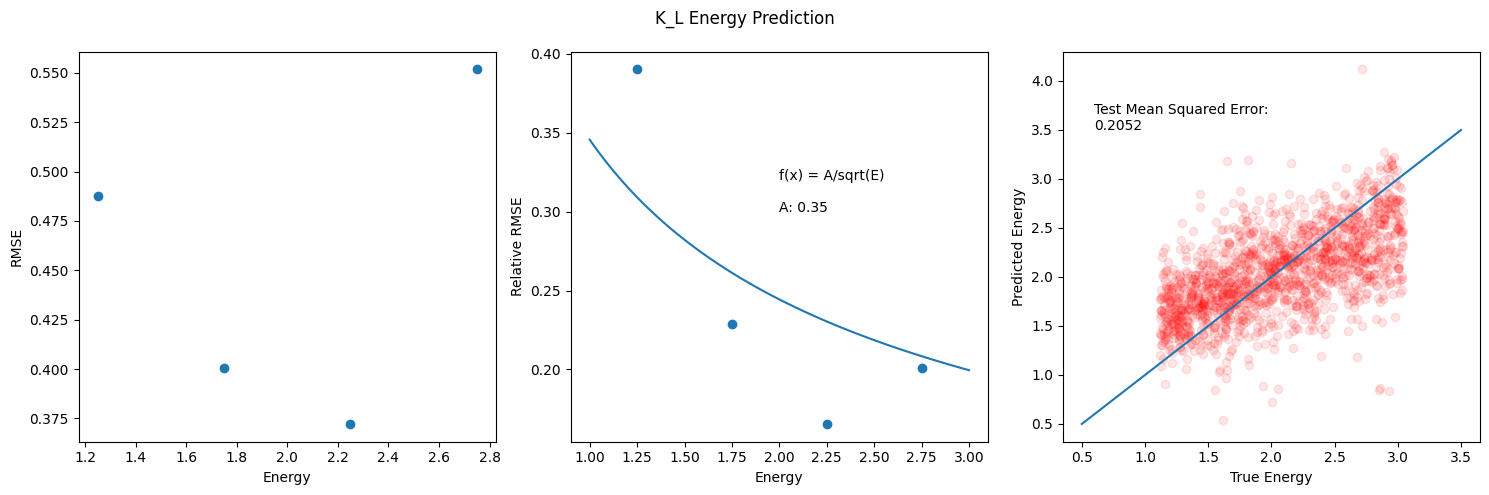

In [62]:
fig,axs = plot.subplots(1,3,figsize = (15,5))
fig.suptitle("K_L Energy Prediction")
axs[0].scatter(rmse_per_bin.keys(),rmse_per_bin.values())
axs[0].set(xlabel="Energy",ylabel = "RMSE")
axs[1].scatter(rmse_per_bin.keys(),np.array(list(rmse_per_bin.values())) / np.array(list(rmse_per_bin.keys())))
axs[1].plot(x_fit,y_fit)
axs[1].set(xlabel="Energy",ylabel = "Relative RMSE")
axs[1].text(2,0.3,f"A: {params[0]:.2f}")
axs[1].text(2,0.32,f"f(x) = A/sqrt(E)")
axs[2].scatter(test_truths,test_preds,alpha = 0.1,color = "r")
axs[2].text(0.6,3.5,f"Test Mean Squared Error:\n{np.mean(list(rmse_per_bin.values()))**2:0.4f}")
axs[2].plot([0.5,3.5],[0.5,3.5])
axs[2].set(xlabel = "True Energy",ylabel = "Predicted Energy")
fig.tight_layout()
plot.savefig(f"plots/GNN/March_17_run_{run_num}_RMSE_k_6.jpeg")

In [230]:
from scipy import optimize

Text(0.1, 4, 'Fit:\npred = m * (summed charge) + b\n(m,b) = (0.0011,1.881)')

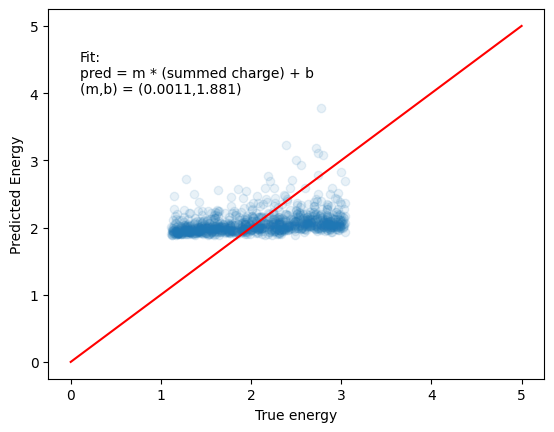

In [293]:
targets = []
total_charges = []
for graph, label in dataset:
    total_charges.append(label[1])
    targets.append(label[0])
def linear_func(x,m,b):
    return m * x + b

total_charges = np.array(total_charges)
targets = np.array(targets)

popt,pcov = optimize.curve_fit(linear_func,total_charges, targets)

pred_energies = linear_func(total_charges,popt[0],popt[1])
plot.scatter(targets[:1000],pred_energies[:1000],alpha = 0.1)
plot.plot([0,5],[0,5],color = 'r')
plot.xlabel("True energy")
plot.ylabel("Predicted Energy")
plot.text(0.1,4,f"Fit:\npred = m * (summed charge) + b\n(m,b) = ({popt[0]:0.4f},{popt[1]:0.3f})")

In [250]:
def rmse(pred,true):
    se_sum = 0
    for i in range(len(pred)):
        error = pred[i] - true[i]
        se_sum += np.square(error)
    return se_sum / len(pred))

In [251]:
rmse(pred_energies,targets)

np.float64(0.2871093736772619)

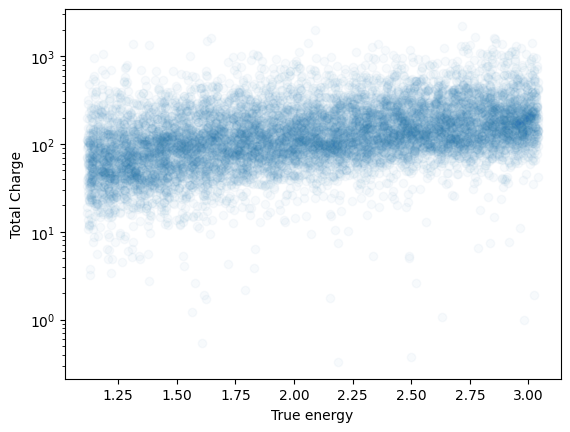

In [290]:
# plot.plot([0,5],[0,5],color = 'r')
plot.scatter(targets,total_charges,alpha = 0.03)

plot.xlabel("True energy")
plot.ylabel("Total Charge")
plot.yscale("log")